# Mask R-CNN

- 객체 탐지 모델으로부터 시작

  - 예측된 경계 상자가 정확하면 분할 네트워크가 할 일은 단순

  - 해당 패치에서 어느 픽셀이 캡처된 클래스에 속하는지, 어느 픽셀이 배경의 일부이고 어느 픽셀이 다른 클래스에 속하는지 분류

- 사전 훈련된 탐지 네트워크와 뒤에 사전 훈련된 분할 네트워크를 하나로 이어서 End-to-End 방식으로 훈련하여 전체 파이프라인의 성능이 좋아짐을 보임

- Facebook AI Research(FAIR)

- 주로 Faster R-CNN에 기반

  - 참고 
    - https://curt-park.github.io/2017-03-17/faster-rcnn/ 

    - https://tensorflow.blog/2017/06/05/from-r-cnn-to-mask-r-cnn/
- 3번째 병렬 분기를 추가해 확장함으로써 각 영역의 요소에 대한 이진 마스크 출력

  - 해당 분류기를 통해 분류와 분할을 분리할 수 있음

  - 분할 분기는 N개의 이진 마스크(다른 일반적인 의미론적 분할 모델처럼 클래스당 한 개)를 출력하도록 정의되지만,  
    다른 분기에 의해 예측된 클래스에 대응하는 마스크만 최종 예측과 훈련 손실을 계산할 때 사용됨

  <img src="https://miro.medium.com/max/6060/1*M_ZhHp8OXzWxEsfWu2e5EA.png">

  <sub>[이미지 출처] https://medium.com/@jonathan_hui/image-segmentation-with-mask-r-cnn-ebe6d793272</sub>



## Mask R-CNN Implement

- [런타임 유형] - GPU 설정

- 코드 참고 
  - https://www.tensorflow.org/tutorials/images/segmentation
  - https://github.com/tensorflow/examples.git

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.7MB 24.8MB/s 


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

build configs


### Oxford-IIIT Pets 데이터 세트를 다운로드

- Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성
- 마스크는 기본적으로 각 픽셀의 레이블
- 각 픽셀은 다음 세 가지 범주 중 하나

  *   class 1 : 애완동물이 속한 픽셀
  *   class 2 : 애완동물과 인접한 픽셀
  *   class 3 : 위에 속하지 않는 경우/주변 픽셀

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5VNAZ5/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5VNAZ5/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


- 이미지를 뒤집는 간단한 확장을 수행합니다. 또한, 영상이 [0,1]로 정규화

- 분할 마스크에서 1을 빼서 레이블이 {0, 1, 2}이 되도록 함

In [14]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [15]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [16]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

- 데이터 세트에는 이미 필요한 몫의 시험과 훈련이 포함되어 있으므로 동일한 분할을 계속 사용


In [17]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [18]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [19]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [23]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')

  plt.show()

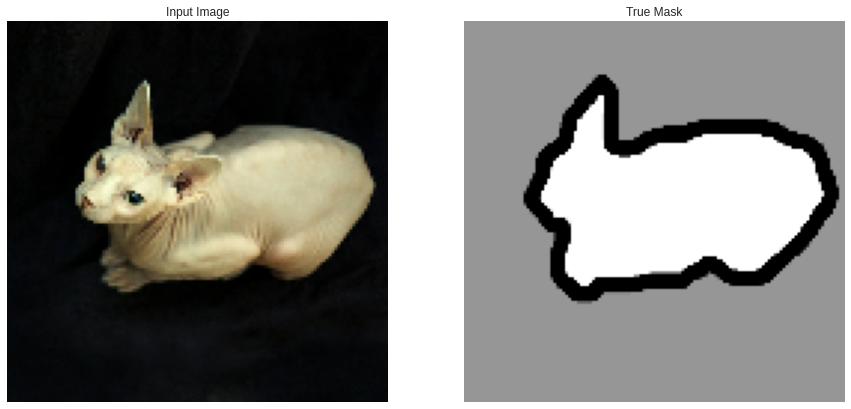

In [24]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

### 모델 정의

- 사용된 모델은 수정된 U-Net
- U-Net은 인코더(다운샘플러)와 디코더(업샘플러)를 포함
- 강력한 기능을 학습하고 훈련 가능한 매개변수의 수를 줄이기 위해 미리 훈련된 모델을 인코더로 사용할 수 있음  
- 인코더는 미리 훈련된 MobileNetV2 모델이 될 것이며 이 모델의 중간 출력이 사용
- 디코더는 Pix2pix 튜토리얼의 TensorFlow 예제에서 이미 구현된 업샘플 블록이 될 것
- 3개의 채널을 출력하는 이유는 픽셀당 3개의 가능한 라벨이 있기 때문
- 각 화소가 세 개의 class로 분류되는 다중 분류라고 생각

In [31]:
OUTPUT_CHANNELS = 3

- 사전 훈련된 MobileNetV2 모델

- 인코더는 전체 학습 과정 중 학습 되지 않음

In [86]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = ['block_1_expand_relu',
               'block_3_expand_relu',
               'block_6_expand_relu',
               'block_13_expand_relu',
               'block_16_project',]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [87]:
up_stack = [pix2pix.upsample(512, 3),
            pix2pix.upsample(256, 3),
            pix2pix.upsample(128, 3),
            pix2pix.upsample(64, 3)]

In [94]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(output_channels, 3,
                                         strides=2, padding='same')
  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### 모델 학습

- 손실 함수는 `loss.sparse_categorical_crossentropy`
  
  - 이 손실 함수를 사용하는 이유는 네트워크가 멀티 클래스 예측과 마찬가지로 픽셀마다 레이블을 할당하려고 하기 때문  
  
  - 실제 분할 마스크에서 각 픽셀은 {0,1,2}를 가지고 있고, 이곳의 네트워크는 세 개의 채널을 출력 
  
  - 기본적으로 각 채널은 클래스를 예측하는 방법을 배우려고 하고 있으며, `loss.sparse_categical_crossentropy`는 그러한 시나리오에 권장되는 손실
  
  - 네트워크의 출력을 사용하여 픽셀에 할당된 레이블은 가장 높은 값을 가진 채널임  
    이것이 create_mask 함수가 하는 일입니다.



In [95]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

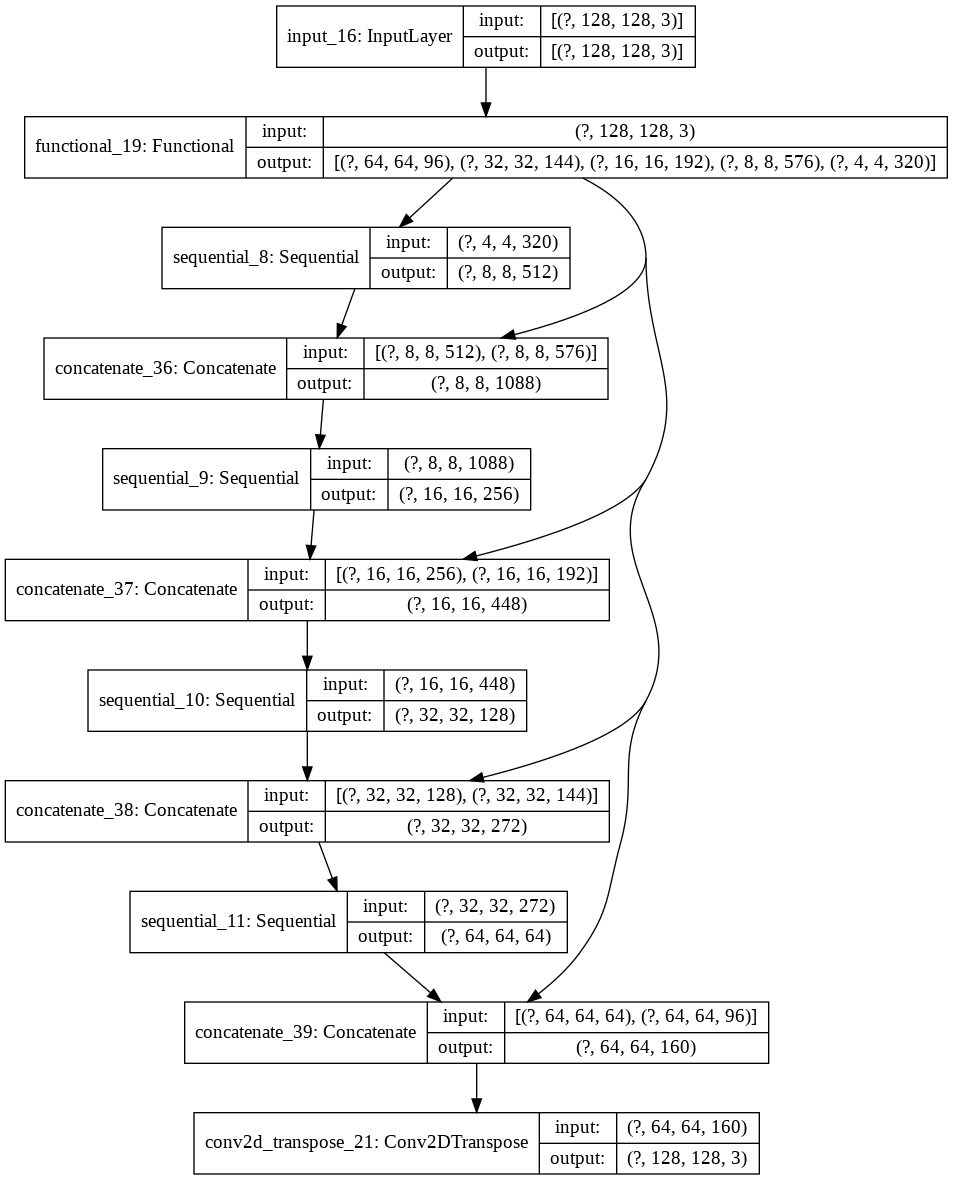

In [96]:
tf.keras.utils.plot_model(model, show_shapes=True)

- 모델을 시험해보고 훈련 전에 예측한 것이 무엇인지 알아봄

In [97]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [111]:
def show_prediction(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

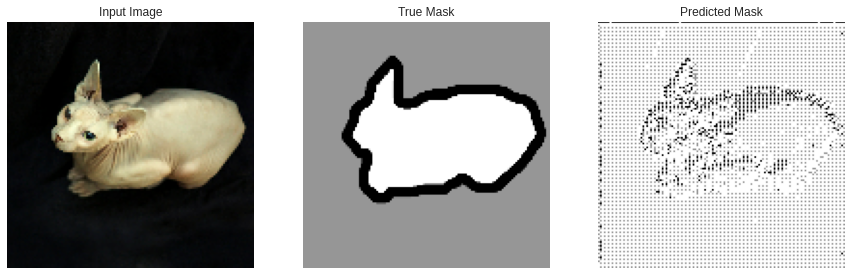

In [99]:
show_prediction()

### 콜백 함수 정의

In [101]:
class DisplayCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_prediction()
    print("{} Epoches".format(epoch+1))

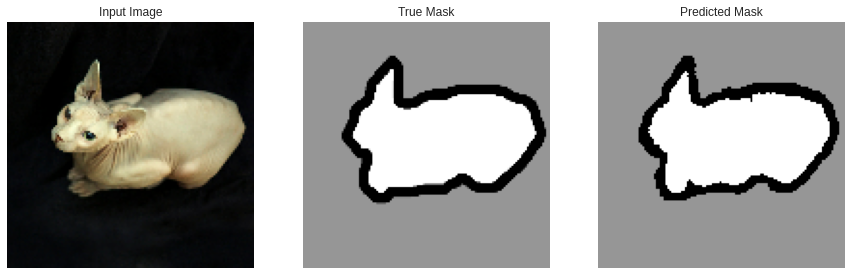

20 Epoches
57/57 [==============================] - 8s 144ms/step - loss: 0.1332 - accuracy: 0.9390 - val_loss: 0.3141 - val_accuracy: 0.8920


In [104]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data = test_dataset,
                          callbacks=[DisplayCallback()])

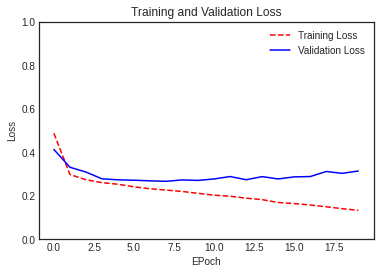

In [109]:
loss = model_history.history['loss']
val_loss= model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss , 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('EPoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 학습된 모델을 활용하여 예측

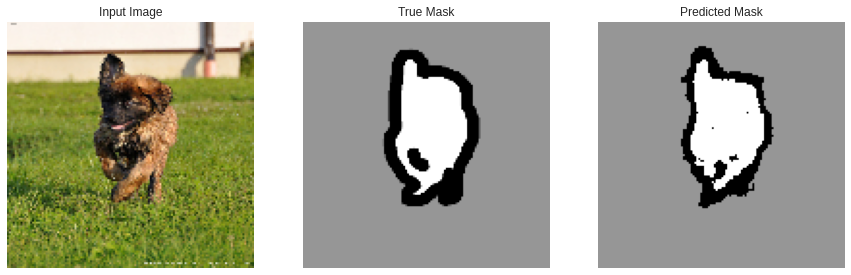

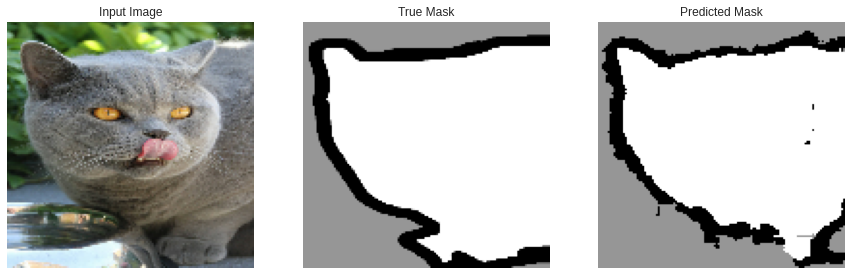

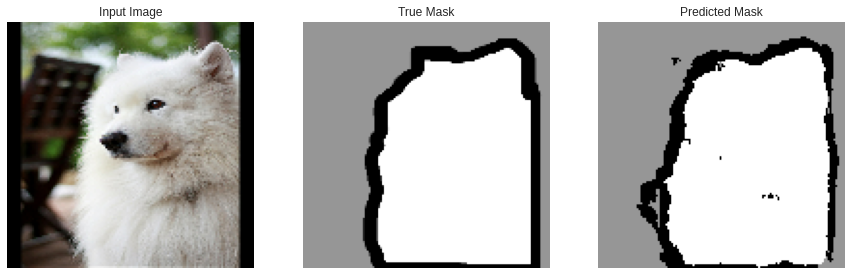

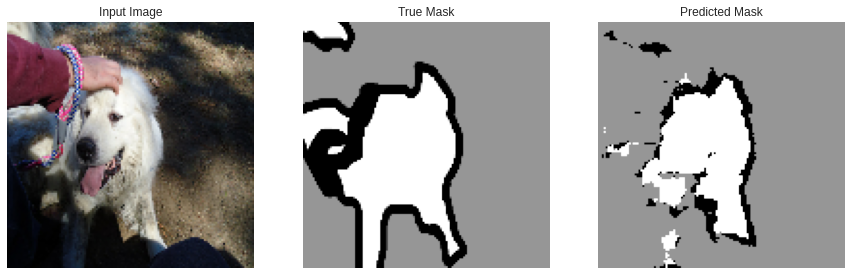

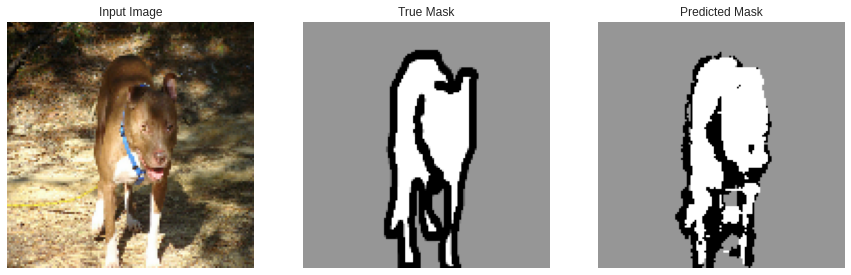

In [112]:
show_prediction(test_dataset, 5)